In [1]:
from polygon import RESTClient
import pandas as pd
import numpy as np
import psycopg2
from psycopg2 import sql    
from tqdm import tqdm
from polygon.rest.models import *
import statsmodels.api as sm
# from functions import *
from datetime import datetime, timedelta
from bs4 import BeautifulSoup
import requests
import warnings
warnings.filterwarnings("ignore")
api_key = "C1ArqE5IR4xXyDhViri8XNXGOdVQr1f7"
client = RESTClient(api_key)

In [2]:
url = "https://en.wikipedia.org/wiki/List_of_S%26P_500_companies"

response = requests.get(url)
soup = BeautifulSoup(response.text, 'html.parser')
table = soup.find('table', {'id': 'constituents'})
symbols = []
names = []
sectors = []
industries = []

for row in table.find('tbody').find_all('tr')[1:]:
    cells = row.find_all('td')
    if len(cells) >= 4:
        symbol = cells[0].text.strip()
        name = cells[1].text.strip()
        sector = cells[3].text.strip()
        industry = cells[4].text.strip()
        symbols.append(symbol)
        names.append(name)
        sectors.append(sector)
        industries.append(industry)

df = pd.DataFrame({
    'Symbol': symbols,
    'Name': names,
    'Sector': sectors,
    'Industry': industries
})


In [3]:
url = 'https://stockanalysis.com/list/nasdaq-100-stocks/'
response = requests.get(url)
soup = BeautifulSoup(response.text, 'html.parser')
res = soup.find_all('a')

In [4]:
us500_l = sorted(df['Symbol'].tolist())
us100_l = [i.text for i in res[38:139]]

In [50]:
import yfinance as yf
df_list = []
for stock in tqdm(us100_l):
    df = yf.download(stock, interval='5m', start=datetime.now() - timedelta(60), progress=False, rounding=2)
    df['code'] = stock
    df_list.append(df)
df = yf.download("^NDX", interval='5m', start=datetime.now() - timedelta(60), progress=False, rounding=2)
df['code'] = "US100"
df_list.append(df)
final = pd.concat(df_list)
final['datetime'] = final.index
pivoted = final.pivot(columns='code', values='Close', index='datetime')
pivoted.to_parquet("US100.parquet")

100%|██████████| 101/101 [00:23<00:00,  4.36it/s]


In [ ]:
import yfinance as yf
df_list = []
for stock in tqdm(us500_l):
    df = yf.download(stock, interval='5m', start=datetime.now() - timedelta(60), progress=False, rounding=2)
    df['code'] = stock
    df_list.append(df)
df = yf.download("^SPX", interval='5m', start=datetime.now() - timedelta(60), progress=False, rounding=2)
df['code'] = "US100"
df_list.append(df)
final = pd.concat(df_list)
final['datetime'] = final.index
pivote = final.pivot(columns='code', values='Close', index='datetime')
pivote.to_parquet("US500.parquet")


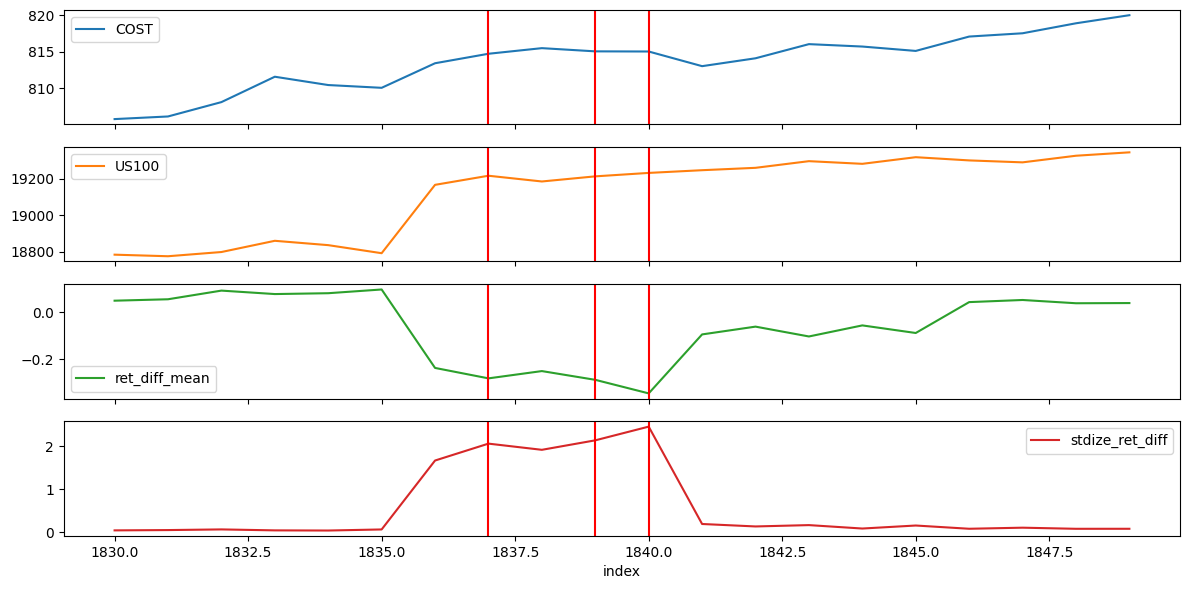

code,COST,US100,ret_diff,ret_diff_std,ret_diff_mean,stdize_ret_diff,index,COST_lag60,TWII_lag60,lag10,direction,target_60mins
index,,,,,,,,,,,,
1837,814.70,19215.71,-0.001005,7.337685,-0.280383,2.049992,1837,819.99,19343.98,813.00,-1,-0.006
1839,815.03,19212.34,-0.002003,7.469718,-0.286634,2.126108,1839,819.33,19299.04,816.02,1,0.005
1840,815.01,19231.19,-0.001006,7.115061,-0.344271,2.442351,1840,819.90,19272.90,815.69,1,0.006
1992,814.82,18420.12,0.022598,10.331059,0.436579,4.276863,1992,814.93,18348.85,828.48,1,0.000
1993,817.59,18579.58,-0.005257,11.196698,0.305797,3.482782,1993,811.88,18294.47,828.77,1,-0.007
1994,821.69,18552.23,0.006487,10.793984,0.485719,5.172825,1994,811.99,18336.29,823.68,1,-0.012
1995,825.32,18516.89,0.006323,10.638807,0.581072,6.114653,1995,814.44,18417.04,818.55,-1,0.013
1996,828.48,18475.92,0.006041,9.935957,0.723827,7.131890,1996,809.61,18345.71,816.43,-1,0.023


In [189]:
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
code = 'COST'
index = "US100"
rolling = 5
ret = pivoted[[code, index]].pct_change()
ret['ret_diff'] = ret[code] - ret[index]
ret['ret_diff_std'] = ret['ret_diff'].rolling(rolling).std() * 1000
ret['ret_diff_mean'] = ret['ret_diff'].rolling(rolling).mean() * 100
ret['stdize_ret_diff'] = abs((ret['ret_diff'] - ret['ret_diff_mean'])*ret['ret_diff_std'])
ret[code] = pivoted[code]
ret[index] = pivoted[index]

ret['index'] = [i for i in range(len(ret))]

# check raise
ret[f'{code}_lag60'] = ret[code].shift(-12)
ret[f'TWII_lag60'] = ret[index].shift(-12)
ret['lag10'] = ret[code].shift(-4)

ret['direction'] = ret.apply(lambda x: -1 if x[code] - x['lag10'] > 0 else 1, axis=1)
ret['target_60mins'] = (np.round((ret[f'{code}_lag60'] - ret[code])/ret[code], 3)) * ret['direction']

# ret['signal_defineby_prev_ret'] = 
# specific print
ret.set_index('index', inplace=True, drop=False)
# start = -54 # -268
start = 1830
end = len(ret)
end = 1850
bm = 2
fig, axes = plt.subplots(nrows=4, ncols=1, figsize=(12, 6), sharex=True)
ret.iloc[start:end, [0, 1, 4, 5]].plot(ax=axes, subplots=True, legend=True)
for index, row in ret.iloc[start:end, :][ret['stdize_ret_diff'] >= bm].iterrows():  
    for ax in axes:
        ax.axvline(row['index'], color='red')
plt.tight_layout()
plt.show()

# check to long or short
ret[ret['stdize_ret_diff'] >= bm]